# Curve fitting energy values from experiment with dephasing and depolarisation
## Table of Contents
- [1. Initialising](#initialising)
    - [Function to add depolarising](#function-to-add-depolarising)
    - [Function to fit the curve manually](#function-to-fit-the-curve-manually)
    - [Load the data and also sort them](#load-the-data-and-also-sort-them)
- [2. Manual curve fitting](#manual-curve-fitting)
- [3. Save the curve fitting values and load it if needed](#save-the-curve-fitting-values-and-load-it-if-needed)



## Initialising
- Make sure that you have a folder name `energy_values_csv` (or whichever folder name you so choose)
- Choose the qubit pair to name all the files generated. 
- Choose the workbook to extract data from

In [66]:
import os

main_folder_name = "energy_values"

if not os.path.exists(main_folder_name):
    os.makedirs(main_folder_name)

In [67]:
# qubit_pair = "QA-QB"
# qubit_pair = "QA-QD"
qubit_pair = "QB-QC"
# qubit_pair = "QC-QD"

import os

folder_name = main_folder_name + "\energy_values_" + qubit_pair 

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\XPS13-9360\AppData\Local\Temp\ipykernel_31124\4260162461.py:8: SyntaxWarning: invalid escape sequence '\e'
  folder_name = main_folder_name + "\energy_values_" + qubit_pair


### 2. Curve that agree with experiments

In [68]:
excel_workbook = 'energy_values_' + qubit_pair + '.xlsx'

In [69]:
import os
import json

filename = f"{folder_name}/rz_dme_value_{qubit_pair}.json"
overwrite_rz_dme_value = True  # Change this to True to force overwrite later

rz_dme_value = None

if os.path.exists(filename):
    with open(filename, 'r') as f:
        rz_dme_value = json.load(f)
    print(f"Loaded rz_dme_value from {filename}")
    print(rz_dme_value)
else:
    print(f"No existing file found at {filename}. Will create it later.")

No existing file found at energy_values\energy_values_QB-QC/rz_dme_value_QB-QC.json. Will create it later.


In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import expm

# --- Unitaries ---
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
H = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
S = np.array([[1, 0], [0, 1j]])
S_dagger = S.conj().T

def zz_unitary(phi):
    return np.diag([
        np.exp(-1j * phi / 2),
        np.exp(1j * phi / 2),
        np.exp(1j * phi / 2),
        np.exp(-1j * phi / 2),
    ])

def dme_heisenberg(phi):
    ZZ_phi = zz_unitary(phi)
    YY_phi = (
        np.kron(S_dagger, I) @ np.kron(H, I) @
        np.kron(I, S_dagger) @ np.kron(I, H) @
        zz_unitary(phi) @
        np.kron(H, I) @ np.kron(S, I) @
        np.kron(I, H) @ np.kron(I, S)
    )
    XX_phi = (
        np.kron(H, I) @ np.kron(I, H) @
        zz_unitary(phi) @
        np.kron(H, I) @ np.kron(I, H)
    )
    return ZZ_phi @ YY_phi @ XX_phi

def RZ(phi):
    return expm(-1j * phi * Z)

def RX(theta):
    return expm(-1j * theta * X)

def RY(theta):
    return expm(-1j * theta * Y)

In [71]:
def ptrace(matrix, index=1, n1=2, n2=2):
    """Partial trace over one subsystem."""
    current_tensor = matrix.reshape([n1, n2, n1, n2])
    if index == 1:
        return np.trace(current_tensor, axis1=1, axis2=3)
    elif index == 2:
        return np.trace(current_tensor, axis1=0, axis2=2)
    else:
        print('Error')

### Function to add depolarising

In [72]:
# Add depolarizing noise to the density matrix
def apply_depolarizing_noise(rho, p=0.5):
    dim = rho.shape[0]
    identity = np.eye(dim)
    return (1 - p) * rho + (p / dim) * identity

def apply_bitflip_error(state, p=0.7):
    return 0.2*(RX(np.pi/2) @ state) + 0.8*state if np.random.rand() < p else state

def apply_dephasing_noise(rho, p=0.5):
    return (1 - p) * rho + p * Z@rho@Z  # Dephasing noise

In [73]:
psi0 = np.array([[1, 0], [0, 0]])

### Function to fit the curve manually

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shifted_theta(theta_list, y_val, delta, ax=None, **plot_kwargs):
    """
    Plot y_val against theta_list + delta, wrapped into [-π/2, π/2],
    and display x-axis ticks with LaTeX π-based labels.

    Parameters:
    - theta_list: np.ndarray, original theta values
    - y_val: np.ndarray, corresponding y values
    - delta: float, amount to shift theta values for plotting
    - ax: optional matplotlib axis
    - plot_kwargs: optional kwargs for plt.scatter or plt.plot()

    Returns:
    - ax: matplotlib axis with the plotted curve
    """
    # Wrap (theta + delta) into [-π/2, π/2]
    wrapped_theta = ((theta_list + delta + np.pi/2) % np.pi) - np.pi/2

    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(wrapped_theta, y_val, **plot_kwargs)

    # Define standard x-ticks and LaTeX labels
    xticks = np.arange(-np.pi/2, np.pi/2 + 1e-6, np.pi/8)
    xtick_labels = [
        r'$-\frac{\pi}{2}$', r'$-\frac{3\pi}{8}$', r'$-\frac{\pi}{4}$', r'$-\frac{\pi}{8}$',
        r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'
    ]

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlim([-np.pi/2 - 0.1, np.pi/2 + 0.1])
    ax.set_xlabel(r"Angle $\theta$ (radians)")
    ax.set_ylabel("y")

    return ax


### Load the data and also sort them

In [75]:
# Define numeric theta_X manually
theta_X = np.array([
    -np.pi/8, -np.pi/5, -2*np.pi/7, -2*np.pi/5, -np.pi/2,
    -3*np.pi/5, -5*np.pi/7, -4*np.pi/5, -7*np.pi/8, -np.pi,
    0,
    np.pi/8, np.pi/5, 2*np.pi/7, 2*np.pi/5, np.pi/2,
    3*np.pi/5, 5*np.pi/7, 4*np.pi/5, 7*np.pi/8, np.pi
])

# Get sort indices and sort theta_X
sorted_indices = np.argsort(theta_X)
theta_X = theta_X[sorted_indices]

# Load data
dfs = pd.read_excel(folder_name + '/' + excel_workbook, sheet_name=None)

for sheet_name, data in dfs.items():
    df = data
    for col in ['E1_ideal', 'E2_ideal', 'E1_meas', 'E2_meas']:
        globals()[f"{col}_{sheet_name}"] = df[col].to_numpy()[sorted_indices]
        print(f"{col}_{sheet_name}")

E1_ideal_ZZ_0
E2_ideal_ZZ_0
E1_meas_ZZ_0
E2_meas_ZZ_0
E1_ideal_ZZ_pi_over_8
E2_ideal_ZZ_pi_over_8
E1_meas_ZZ_pi_over_8
E2_meas_ZZ_pi_over_8
E1_ideal_ZZ_pi_over_4
E2_ideal_ZZ_pi_over_4
E1_meas_ZZ_pi_over_4
E2_meas_ZZ_pi_over_4


In [76]:
theta = theta_X / 2
rz_dme_value = {} if rz_dme_value is None or overwrite_rz_dme_value else rz_dme_value

# Data for both qubits
data = {
    'E1': {
        'phi0': E1_meas_ZZ_0,
        'phi8': E1_meas_ZZ_pi_over_8,
        'phi4': E1_meas_ZZ_pi_over_4
    },
    'E2': {
        'phi0': E2_meas_ZZ_0,
        'phi8': E2_meas_ZZ_pi_over_8,
        'phi4': E2_meas_ZZ_pi_over_4
    }
}

# Process each qubit and phi shift
for qubit, phi_dict in data.items():
    for phi_label, values in phi_dict.items():
        i = np.argmax(values)
        max_y = round(values[i], 2)
        th = round(theta[i], 2)
        noise = round(1 - max_y, 2)
        delta = round(th, 2)

        print(f"{phi_label} shift ({qubit}):")
        print(f"  max y = {max_y}")
        print(f"  θ = {th}")
        print(f"  estimated decoherence probability = {noise}")
        print(f"  estimated delta = {delta}")

        rz_dme_value[f"{phi_label} {qubit} p"] = noise
        rz_dme_value[f"{phi_label} {qubit} Delta"] = -delta  # negate per your convention


phi0 shift (E1):
  max y = 0.69
  θ = 0.0
  estimated decoherence probability = 0.31
  estimated delta = 0.0
phi8 shift (E1):
  max y = 0.57
  θ = 0.2
  estimated decoherence probability = 0.43
  estimated delta = 0.2
phi4 shift (E1):
  max y = 0.33
  θ = 0.0
  estimated decoherence probability = 0.67
  estimated delta = 0.0
phi0 shift (E2):
  max y = 0.97
  θ = 0.31
  estimated decoherence probability = 0.03
  estimated delta = 0.31
phi8 shift (E2):
  max y = 0.79
  θ = 0.0
  estimated decoherence probability = 0.21
  estimated delta = 0.0
phi4 shift (E2):
  max y = 0.47
  θ = 0.0
  estimated decoherence probability = 0.53
  estimated delta = 0.0


In [77]:
print(rz_dme_value)

{'phi0 E1 p': np.float64(0.31), 'phi0 E1 Delta': np.float64(-0.0), 'phi8 E1 p': np.float64(0.43), 'phi8 E1 Delta': np.float64(-0.2), 'phi4 E1 p': np.float64(0.67), 'phi4 E1 Delta': np.float64(-0.0), 'phi0 E2 p': np.float64(0.03), 'phi0 E2 Delta': np.float64(-0.31), 'phi8 E2 p': np.float64(0.21), 'phi8 E2 Delta': np.float64(-0.0), 'phi4 E2 p': np.float64(0.53), 'phi4 E2 Delta': np.float64(-0.0)}


## Manual curve fitting

In [89]:
colors = ['C0','C1','C2']

# colors = [
#     "navy",
#     "darkviolet",
#     "firebrick",
#     "darkgreen",
#     "darkslateblue",
#     "indigo",
#     "darkcyan",
#     "maroon"
# ]

In [90]:
# rz_dme_value = {'0 noise' : 0, 'pi 4 noise' : 0, 'pi 8 noise' : 0, # higher -> smaller amplitude
#                 '0 shift' : 0, 'pi 4 shift' : 0, 'pi 8 shift' : 0} # positive shift right


d:\Program Files\python\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Program Files\python\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Program Files\python\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Program Files\python\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Program Files\python\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
d:\Program Files\python\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary par

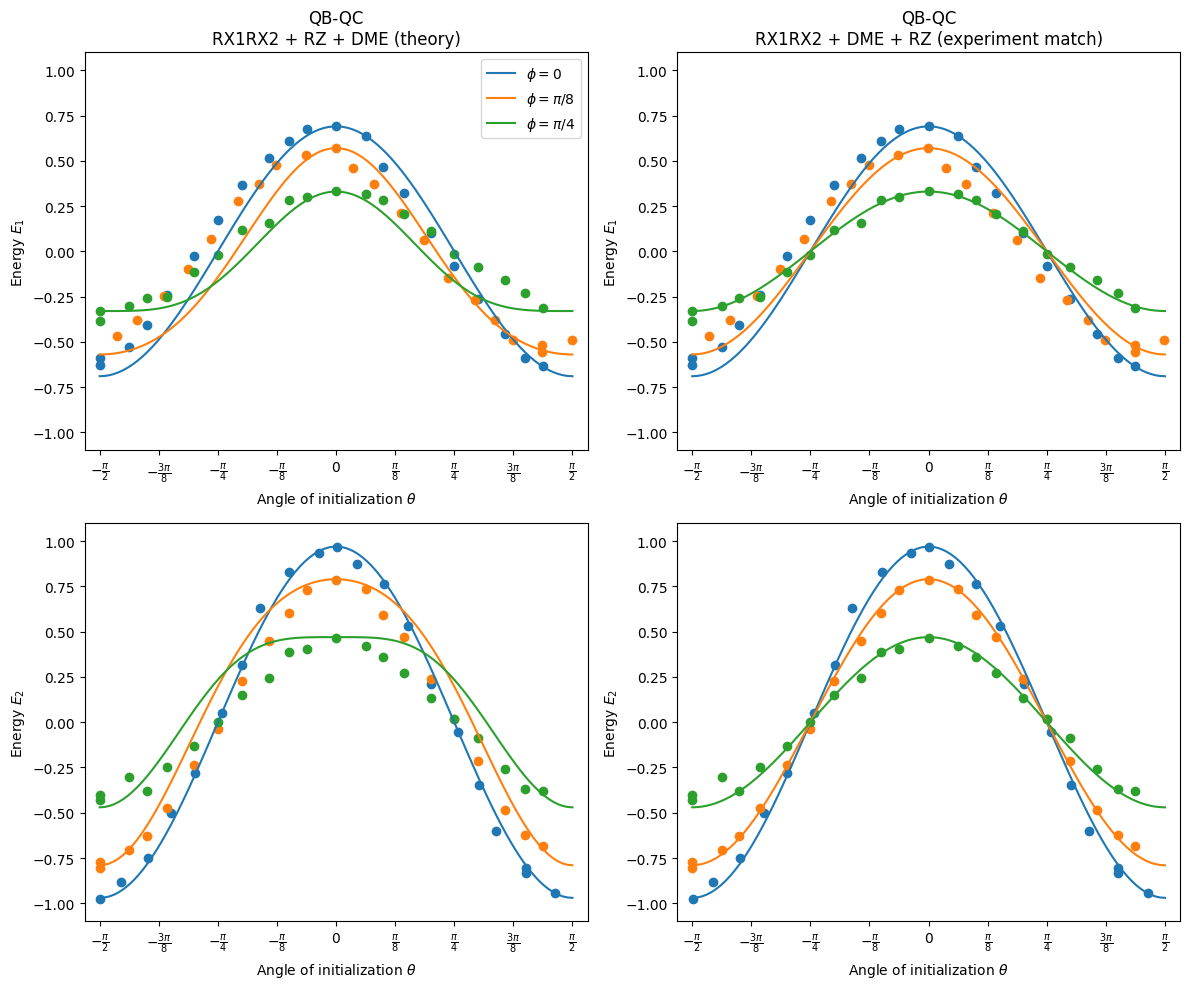

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 cols
(ax1, ax2), (ax3, ax4) = axs

theta_list = np.linspace(-np.pi/2, np.pi/2, 100)
phi_list = [0, np.pi/8, np.pi/4]
phi_name = [r"$0$", r"$\pi/8$", r"$\pi/4$"]
phi_keys = ['phi0', 'phi8', 'phi4']

qubits = ['E1', 'E2']
noise_keys = {f'{phi} {q} p': rz_dme_value[f'{phi} {q} p'] for q in qubits for phi in phi_keys}
shift_keys = {f'{phi} {q} Delta': rz_dme_value[f'{phi} {q} Delta'] for q in qubits for phi in phi_keys}

# --- Subsystem 1 (E1) and subsystem 2 (E2) with RX1RX2 + RZ + DME ---
for idx, phi in enumerate(phi_list):
    unitary_list = [dme_heisenberg(phi) @ np.kron(I, RZ(phi)) @ np.kron(RX(theta), RX(theta)) for theta in theta_list]
    final_matrices = [U @ np.kron(psi0, psi0) @ U.conj().T for U in unitary_list]

    # Apply E1 noise
    noise_e1 = noise_keys[f'{phi_keys[idx]} E1 p']
    noisy_matrices_e1 = [apply_depolarizing_noise(M, noise_e1) for M in final_matrices]
    subsystem_1 = [ptrace(M, 1) for M in noisy_matrices_e1]
    energy_1 = [s[0][0] - s[1][1] for s in subsystem_1]
    ax1.plot(theta_list, energy_1, label=r'$\phi =$' + phi_name[idx], color=colors[idx])

    # Apply E2 noise separately
    noise_e2 = noise_keys[f'{phi_keys[idx]} E2 p']
    noisy_matrices_e2 = [apply_depolarizing_noise(M, noise_e2) for M in final_matrices]
    subsystem_2 = [ptrace(M, 2) for M in noisy_matrices_e2]
    energy_2 = [s[0][0] - s[1][1] for s in subsystem_2]
    ax3.plot(theta_list, energy_2, label=r'$\phi =$' + phi_name[idx], color=colors[idx])

    # Plot shifted experimental data for both subsystems
    e1_meas = E1_meas_ZZ_0 if idx == 0 else E1_meas_ZZ_pi_over_8 if idx == 1 else E1_meas_ZZ_pi_over_4
    e2_meas = E2_meas_ZZ_0 if idx == 0 else E2_meas_ZZ_pi_over_8 if idx == 1 else E2_meas_ZZ_pi_over_4
    plot_shifted_theta(theta_X/2, e1_meas, shift_keys[f'{phi_keys[idx]} E1 Delta'], ax=ax1, color=colors[idx])
    plot_shifted_theta(theta_X/2, e2_meas, shift_keys[f'{phi_keys[idx]} E2 Delta'], ax=ax3, color=colors[idx])

ax1.set_xlabel(r'Angle of initialization $\theta$')
ax1.set_ylabel(r'Energy $E_1$')
ax1.set_title(qubit_pair + '\nRX1RX2 + RZ + DME (theory)')
ax1.set_ylim([-1.1, 1.1])
ax1.legend()

ax3.set_xlabel(r'Angle of initialization $\theta$')
ax3.set_ylabel(r'Energy $E_2$')
# ax3.set_title(qubit_pair + '\nRX1RX2 + RZ + DME (theory)')
ax3.set_ylim([-1.1, 1.1])
# ax3.legend()

# --- Subsystem 1 (E1) and subsystem 2 (E2) with RX1RX2 + DME + RZ ---
for idx, phi in enumerate(phi_list):
    unitary_list = [np.kron(I, RZ(phi)) @ dme_heisenberg(phi) @ np.kron(RX(theta), RX(theta)) for theta in theta_list]
    final_matrices = [U @ np.kron(psi0, psi0) @ U.conj().T for U in unitary_list]

    # E1 noise
    noise_e1 = noise_keys[f'{phi_keys[idx]} E1 p']
    noisy_matrices_e1 = [apply_depolarizing_noise(M, noise_e1) for M in final_matrices]
    subsystem_1 = [ptrace(M, 1) for M in noisy_matrices_e1]
    energy_1 = [s[0][0] - s[1][1] for s in subsystem_1]
    ax2.plot(theta_list, energy_1, label=r'$\phi =$' + phi_name[idx], color=colors[idx])

    # E2 noise
    noise_e2 = noise_keys[f'{phi_keys[idx]} E2 p']
    noisy_matrices_e2 = [apply_depolarizing_noise(M, noise_e2) for M in final_matrices]
    subsystem_2 = [ptrace(M, 2) for M in noisy_matrices_e2]
    energy_2 = [s[0][0] - s[1][1] for s in subsystem_2]
    ax4.plot(theta_list, energy_2, label=r'$\phi =$' + phi_name[idx], color=colors[idx])

    e1_meas = E1_meas_ZZ_0 if idx == 0 else E1_meas_ZZ_pi_over_8 if idx == 1 else E1_meas_ZZ_pi_over_4
    e2_meas = E2_meas_ZZ_0 if idx == 0 else E2_meas_ZZ_pi_over_8 if idx == 1 else E2_meas_ZZ_pi_over_4
    plot_shifted_theta(theta_X/2, e1_meas, shift_keys[f'{phi_keys[idx]} E1 Delta'], ax=ax2, color=colors[idx])
    plot_shifted_theta(theta_X/2, e2_meas, shift_keys[f'{phi_keys[idx]} E2 Delta'], ax=ax4, color=colors[idx])

ax2.set_xlabel(r'Angle of initialization $\theta$')
ax2.set_ylabel(r'Energy $E_1$')
ax2.set_title(qubit_pair + '\nRX1RX2 + DME + RZ (experiment match)')
ax2.set_ylim([-1.1, 1.1])
# ax2.legend()

ax4.set_xlabel(r'Angle of initialization $\theta$')
ax4.set_ylabel(r'Energy $E_2$')
# ax4.set_title(qubit_pair + '\nRX1RX2 + DME + RZ (experiment match)')
ax4.set_ylim([-1.1, 1.1])
# ax4.legend()

fig.tight_layout()
fig.savefig(folder_name + '/energy_comparison_' + qubit_pair + '.pdf')
plt.show()


## Save the curve fitting values and load it if needed

In [81]:
if rz_dme_value is None or overwrite_rz_dme_value:
    with open(filename, 'w') as f:
        json.dump(rz_dme_value, f, indent=2)
    print(f"Saved rz_dme_value to {filename}")
else:
    print(f"File already exists. Not overwriting {filename}. Set overwrite_rz_dme_value = True to force save.")


Saved rz_dme_value to energy_values\energy_values_QB-QC/rz_dme_value_QB-QC.json
